# AUEB M.Sc. in Data Science (part-time)

### 2024.04 - 2024.06

## PART 05
### EXERCISE 03: POS Tagging with Stacked CNNs: Incorporating N-gram Filters and Residual Connections Using Keras/TensorFlow


**Course**: Text Analytics   
**Authors**:
Anagnos Theodoros (p3352323) -
Michalopoulos Ioannis (p3352314) -
Kafantaris Panagiotis (p3352328) -  
Vigkos Ioannis (p3352326)

**Date**: 2024-05-04

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!nvidia-smi

Thu Jun  6 18:39:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install conllu

### Libraries

In [ ]:
## Data Handling and Parsing
import os
from conllu import parse
import requests
from collections import Counter
import numpy as np

## Word Embeddings
import gensim.downloader as api

## Preprocessing
from nltk.util import ngrams
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split  # Importing train_test_split

## Metrics and Evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.exceptions import UndefinedMetricWarning

## Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, add, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.regularizers import l2

## Plotting
import matplotlib.pyplot as plt

## Other
import warnings

### Functions

In [ ]:
# Function for downloading dataset
def download_dataset(url, filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

In [ ]:
# Function for parsing conllu files and extracting sentences
def parse_conllu(file_path):
    """
    Parsed the given conllu file and extracted sentences using the 'conllu' library.
    """
    # Opening the file in read mode with UTF-8 encoding
    with open(file_path, "r", encoding="utf-8") as f:
        # Reading the entire content of the file
        data = f.read()
        # Parsing the data to extract sentences using the 'conllu' library
        sentences = parse(data)
    # Returning the list of parsed sentences
    return sentences

In [ ]:
# Function for parsing and printing head and tail of the dataset along with initial document length
def print_head_tail_with_length(file_path, num_lines=5):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.readlines()
        # Calculating the initial document length (number of sentences)
        initial_document_length = sum(1 for line in data if line.strip() == "")
        # Printing head of the dataset
        print(f"Head of {file_path}:")
        print("".join(data[:num_lines]))
        print("\n")
        # Printing tail of the dataset
        print(f"Tail of {file_path}:")
        print("".join(data[-num_lines:]))
        print("\n")
        # Printing the initial document length
        print(f"Initial Document Length (number of sentences) for {file_path}: {initial_document_length}\n")

In [ ]:
# Function for extracting words and tags from parsed sentences
def extract_words_and_tags(sentences):
    """
    Extracted words and corresponding POS tags from parsed sentences.
    """
    words = []
    tags = []
    # Iterating over each parsed sentence
    for sentence in sentences:
        sentence_words = []
        sentence_tags = []
        # Iterating over each token in the sentence
        for token in sentence:
            if token['form'] and token['upostag']:
                sentence_words.append(token['form'])  # Extracting the word form
                sentence_tags.append(token['upostag'])  # Extracting the POS tag
        # Appending the extracted words and tags to their respective lists
        words.append(sentence_words)
        tags.append(sentence_tags)
    # Returning the lists of words and tags
    return words, tags

In [ ]:
# Function for converting all words to lowercase
def convert_to_lowercase(words):
    return [[word.lower() for word in sentence] for sentence in words]

In [ ]:
# Function to flatten a nested list
def list_flat_data(alist):
    """
    Flatten a nested list into a single list.
    """
    flat_list = []
    for sublist in alist:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [ ]:
# Function to convert to windowed dataset
def convert_to_window_dataset(data, window_size, pad_symbol='</s>'):
    """
    Converted sentences and POS tags to a windowed dataset with padding.
    """
    z_sentences = data[0]  # Extracted sentences
    z_pos_tags = list_flat_data(data[1])  # Flattened POS tags

    windowed_sentences = []  # Initialized list to hold windowed sentences

    # Iterated over each sentence in the dataset
    for sentence in z_sentences:
        # Generated n-grams for each sentence with padding
        gen = ngrams(sentence, window_size, pad_left=True, pad_right=True, left_pad_symbol=pad_symbol, right_pad_symbol=pad_symbol)

        # Appended the generated windows to the list, skipping initial and final padding windows
        for f in list(gen)[window_size//2:-(window_size//2)]:
            windowed_sentences.append(f)

    return windowed_sentences, z_pos_tags

In [ ]:
# Function to create vocabulary from the flattened train windows
def create_vocabulary_from_windows(train_windows):
    """
    Create a vocabulary from the flattened train windows.

    Parameters:
    - train_windows (list of list of str): The windowed data containing words.

    Returns:
    - vocabulary (dict): A dictionary mapping each unique word to a unique index.
    """
    # Flatten the windowed data
    flat_train_windows = list_flat_data(train_windows)

    # Get all unique words in the train set and make a vocabulary out of them
    train_vocab = set(flat_train_windows)
    vocabulary = {v: k for k, v in enumerate(train_vocab)}

    return vocabulary

In [ ]:
def create_embedding_matrix(vocab, wv, embedding_dim=300):
    """
    Create an embedding matrix for the vocabulary using pre-trained word embeddings.

    Parameters:
    - vocab (dict): The vocabulary mapping words to indices.
    - wv (KeyedVectors): The pre-trained word vectors.
    - embedding_dim (int): The dimensionality of the embeddings. Default is 300.

    Returns:
    - embedding_matrix (np.array): The embedding matrix where each row corresponds to a word's embedding.
    """
    # Initializing the embedding matrix with zeros
    embedding_matrix = np.zeros((len(vocab), embedding_dim))

    # Populating the embedding matrix with vectors from the pre-trained model
    for word, idx in vocab.items():
        if word in wv:
            embedding_matrix[idx] = wv[word]

    return embedding_matrix

In [ ]:
# Defining a function to convert windows of words to tokenized format using the vocabulary
def tokenize_windows(windows, vocab):
    # Initializing an empty list to hold tokenized windows
    tokenized_windows = []

    # Iterating over each sentence in the windows
    for sentence in windows:
        # Initializing an empty list to hold tokenized sentence
        tokenized_sentence = []

        # Iterating over each token in the sentence
        for token in sentence:
            # Checking if the token is in the vocabulary and appending its index, otherwise using the index of '</s>'
            if token in vocab:
                tokenized_sentence.append(vocab[token])
            else:
                tokenized_sentence.append(vocab['</s>'])

        # Appending the tokenized sentence to the list of tokenized windows
        tokenized_windows.append(tokenized_sentence)

    # Returning the list of tokenized windows
    return tokenized_windows

### Classes

In [ ]:
# Custom callback for additional metrics
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        # Initializing the callback with validation data
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        # Predicting on the validation data at the end of each epoch
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        # Extracting the true labels from the validation data
        val_targ = np.argmax(self.validation_data[1], -1)

        # Calculating the weighted F1 score for the validation data
        _val_f1 = f1_score(val_targ, val_predict, average="weighted", zero_division=0)
        # Calculating the weighted recall score for the validation data
        _val_recall = recall_score(val_targ, val_predict, average="weighted", zero_division=0)
        # Calculating the weighted precision score for the validation data
        _val_precision = precision_score(val_targ, val_predict, average="weighted", zero_division=0)

        # Logging the calculated metrics
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision

        # Printing the calculated metrics
        print(f" — val_f1: {_val_f1:.4f} — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f}")
        return

## Data Preprocessing

### Downloading the dataset and parsing the conllu files to extract sentences, words, and POS tags

In [ ]:
# Defining URLs of the datasets for training, development, and testing
urls = {
    "train": "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu"
}

In [ ]:
# Downloading the training dataset and saving it locally
for key, url in urls.items():
    filename = f"en_ewt_{key}.conllu"
    download_dataset(url, filename)

In [ ]:
# Printing dataset names
print("Downloaded datasets:")
for key in urls.keys():
    print(f"en_ewt_{key}.conllu")

Downloaded datasets:
en_ewt_train.conllu


In [ ]:
# Printing head, tail, and initial document length for each dataset
for key in urls.keys():
    filename = f"en_ewt_{key}.conllu"
    print("-----------\n")
    print_head_tail_with_length(filename)

-----------

Head of en_ewt_train.conllu:
# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000
# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001
# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
1	Al	Al	PROPN	NNP	Number=Sing	0	root	0:root	SpaceAfter=No



Tail of en_ewt_train.conllu:
23	my	my	PRON	PRP$	Case=Gen|Number=Sing|Person=1|Poss=Yes|PronType=Prs	24	nmod:poss	24:nmod:poss	_
24	car	car	NOUN	NN	Number=Sing	21	obl	21:obl:on	SpaceAfter=No
25	)	)	PUNCT	-RRB-	_	10	punct	10:punct	SpaceAfter=No
26	.	.	PUNCT	.	_	4	punct	4:punct	_




Initial Document Length (number of sentences) for en_ewt_train.conllu: 12544



Parsed the training, development, and test datasets to extract words and POS tags. Converted all words to lowercase for consistency and printed sample data for verification.

In [ ]:
# Parsing the training dataset
train_sentences = parse_conllu("en_ewt_train.conllu")

# Printing sample parsed sentences for verification
print("Sample parsed sentences from training data:")
print(train_sentences[0:5])
print("\n")

# Extracting words and tags from the parsed sentences
all_words, all_tags = extract_words_and_tags(train_sentences)

# Splitting the dataset into train, development, and test sets (70-15-15 ratio)
train_words, temp_words, train_tags, temp_tags = train_test_split(all_words, all_tags, test_size=0.3, random_state=42)
dev_words, test_words, dev_tags, test_tags = train_test_split(temp_words, temp_tags, test_size=0.5, random_state=42)

# Printing the sizes of the datasets
print("Size of train_words:", len(train_words))
print("Size of dev_words:", len(dev_words))
print("Size of test_words:", len(test_words))
print("\n")
print("Size of train_tags:", len(train_tags))
print("Size of dev_tags:", len(dev_tags))
print("Size of test_tags:", len(test_tags))
print("\n")

Sample parsed sentences from training data:
[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, ., metadata={newdoc id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000", sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001", newpar id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001", text: "Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border."}>, TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ], metadata={sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0002", text: "[This killing of a respected cleric will be causing us trouble for years to come.]"}>, TokenList<DPA, :, Iraqi, authorities, announced, that, they, had, busted, up, 3, terro

### Creating sliding windows for words and align the corresponding tags

In [ ]:
# Example window size
window_size = 5

# Creating sliding windows for train and dev datasets
train_windows, train_window_tags = convert_to_window_dataset((train_words, train_tags), window_size)
dev_windows, dev_window_tags = convert_to_window_dataset((dev_words, dev_tags), window_size)
test_windows, test_window_tags = convert_to_window_dataset((test_words, test_tags), window_size)

# Printing sample windowed sentences and tags for verification
print("Sample windowed sentences from training data:\n")
print("Windows:", train_windows[:25])
print("\n")
print("Tags:", train_window_tags[:25])
print("\n")

# Printing sample windowed sentences and tags for verification
print("Sample windowed sentences from training data:\n")
for i in range(5):
    print(f"Window {i+1}: {train_windows[i]}")
    print(f"Tags {i+1}: {train_window_tags[i]}")
    print("\n")

print("Sample windowed sentences from development data:\n")
for i in range(5):
    print(f"Window {i+1}: {dev_windows[i]}")
    print(f"Tags {i+1}: {dev_window_tags[i]}")
    print("\n")

# Printing sizes of the windowed datasets
print("Size of train_windows:", len(train_windows))
print("Size of train_window_tags:", len(train_window_tags))
print("\n")
print("Size of dev_windows:", len(dev_windows))
print("Size of dev_window_tags:", len(dev_window_tags))

Sample windowed sentences from training data:

Windows: [('</s>', '</s>', 'mb', '</s>', '</s>'), ('</s>', '</s>', 'I', 'was', 'not'), ('</s>', 'I', 'was', 'not', 'happy'), ('I', 'was', 'not', 'happy', 'with'), ('was', 'not', 'happy', 'with', 'the'), ('not', 'happy', 'with', 'the', 'way'), ('happy', 'with', 'the', 'way', 'they'), ('with', 'the', 'way', 'they', 'looked'), ('the', 'way', 'they', 'looked', ','), ('way', 'they', 'looked', ',', 'very'), ('they', 'looked', ',', 'very', 'wavy'), ('looked', ',', 'very', 'wavy', ','), (',', 'very', 'wavy', ',', 'uneven'), ('very', 'wavy', ',', 'uneven', 'edges'), ('wavy', ',', 'uneven', 'edges', ','), (',', 'uneven', 'edges', ',', 'and'), ('uneven', 'edges', ',', 'and', 'with'), ('edges', ',', 'and', 'with', 'the'), (',', 'and', 'with', 'the', 'exception'), ('and', 'with', 'the', 'exception', 'of'), ('with', 'the', 'exception', 'of', '1'), ('the', 'exception', 'of', '1', ','), ('exception', 'of', '1', ',', 'there'), ('of', '1', ',', 'there', 'is

### Creating a vocabulary

In [ ]:
# Creating the vocabulary
vocabulary = create_vocabulary_from_windows(train_windows + dev_windows + test_windows)

# Printing the vocabulary for verification
print("Word Vocabulary (first 30 items):\n", list(vocabulary.items())[:30])
print("\n")
print("Word Vocabulary (last 30 items):\n", list(vocabulary.items())[-30:])
print("\n")

# Printing sizes of the vocabularies
print("Size of Word Vocabulary:\n", len(vocabulary))

Word Vocabulary (first 30 items):
 [('Fax.', 0), ('drink', 1), ('mango', 2), ('ACIA', 3), ('closer', 4), ('yeaa', 5), ('footwear', 6), ('sided', 7), ('11:45', 8), ('modernizing', 9), ('dusting', 10), ('clothes', 11), ('ALSO', 12), ('Foot', 13), ('Baffled', 14), ('lead', 15), ('utilitarianism', 16), ('analysts', 17), ('manage', 18), ('Incredible', 19), ('lean', 20), ('aspiration', 21), ('desparate', 22), ('series', 23), ('Mr.', 24), ('losses', 25), ('counseling', 26), ('Sstaff', 27), ('EIR', 28), ('accomplish', 29)]


Word Vocabulary (last 30 items):
 [('conducting', 20172), ('theirs', 20173), ('drove', 20174), ('blacksmithing', 20175), ('misfortune', 20176), ('Enterprise', 20177), ('contribution', 20178), ('Helps', 20179), ('reneged', 20180), ('02-05-02.doc', 20181), ('youngsteers', 20182), ("governor's", 20183), ('birds', 20184), ('http://www.collectinghistory.net/chernobyl/', 20185), ('IBM', 20186), ('militants', 20187), ('3/9/00', 20188), ('node', 20189), ('ranch', 20190), ('Sin', 2

In [ ]:
# Create a vocabulary for train_window_tags
train_target = set(train_window_tags)
train_target = {v: k for k, v in enumerate(train_target)}

# Print samples and sizes for verification
print("Sample of train_window_tags (first 5):", train_window_tags[:5])
print("Size of train_target vocabulary:", len(train_target))

# Printing a sample of the train_target vocabulary
print("Sample of train_target vocabulary (first 10 items):", list(train_target.items())[:10])

Sample of train_window_tags (first 5): ['PROPN', 'PRON', 'AUX', 'PART', 'ADJ']
Size of train_target vocabulary: 18
Sample of train_target vocabulary (first 10 items): [('_', 0), ('ADV', 1), ('CCONJ', 2), ('INTJ', 3), ('PROPN', 4), ('ADJ', 5), ('PUNCT', 6), ('NOUN', 7), ('AUX', 8), ('VERB', 9)]


### Load pre-trained word embeddings (Word2Vec)

In [ ]:
# Loading pre-trained Word2Vec embeddings
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### Mapping the words in the windows to their corresponding embeddings

In [ ]:
# Creating the embedding matrix for the training vocabulary
embedding_matrix = create_embedding_matrix(vocabulary, wv)

# Printing a sample of the embedding matrix
print("Sample embeddings:\n", embedding_matrix[:5])

Sample embeddings:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.13671875 -0.27734375  0.04736328 ... -0.02233887  0.11767578
  -0.06689453]
 [-0.27148438  0.09228516  0.08789062 ...  0.11621094  0.19921875
   0.24121094]
 [-0.06494141  0.01019287  0.17480469 ... -0.09570312  0.07226562
  -0.21679688]
 [-0.0011673  -0.27929688  0.11083984 ...  0.06542969 -0.06030273
  -0.12890625]]


### Tokenizing the train and dev windows using the created vocabulary

In [ ]:
# Tokenizing the train, dev, and test windows
train_windows_tokenized = tokenize_windows(train_windows, vocabulary)
dev_windows_tokenized = tokenize_windows(dev_windows, vocabulary)
test_windows_tokenized = tokenize_windows(test_windows, vocabulary)

# Printing sample tokenized train windows for verification
print("Sample tokenized train windows (first 25):\n", train_windows_tokenized[:25])
print("\n")

# Printing sample tokenized dev windows for verification
print("Sample tokenized dev windows (first 25):\n", dev_windows_tokenized[:25])
print("\n")

# Printing sizes of tokenized windows for verification
print("Size of tokenized train windows:", len(train_windows_tokenized))
print("Size of tokenized dev windows:", len(dev_windows_tokenized))
print("\n")

# Printing a sample of the tag-to-index mapping
target_sample = list(train_target.items())[:25]
print("Sample target (tag to index):\n", target_sample)
print("Size of target dictionary:", len(train_target))

Sample tokenized train windows (first 25):
 [[701, 701, 13808, 701, 701], [701, 701, 3392, 8489, 8443], [701, 3392, 8489, 8443, 19144], [3392, 8489, 8443, 19144, 13814], [8489, 8443, 19144, 13814, 11229], [8443, 19144, 13814, 11229, 813], [19144, 13814, 11229, 813, 16228], [13814, 11229, 813, 16228, 19069], [11229, 813, 16228, 19069, 11925], [813, 16228, 19069, 11925, 7268], [16228, 19069, 11925, 7268, 1792], [19069, 11925, 7268, 1792, 11925], [11925, 7268, 1792, 11925, 7667], [7268, 1792, 11925, 7667, 11968], [1792, 11925, 7667, 11968, 11925], [11925, 7667, 11968, 11925, 16056], [7667, 11968, 11925, 16056, 13814], [11968, 11925, 16056, 13814, 11229], [11925, 16056, 13814, 11229, 398], [16056, 13814, 11229, 398, 2562], [13814, 11229, 398, 2562, 4555], [11229, 398, 2562, 4555, 11925], [398, 2562, 4555, 11925, 14733], [2562, 4555, 11925, 14733, 8912], [4555, 11925, 14733, 8912, 15120]]


Sample tokenized dev windows (first 25):
 [[701, 701, 11341, 7250, 10976], [701, 11341, 7250, 10976, 

### Encoding the POS tags using LabelEncoder and OneHotEncoder

In [ ]:
# Initializing LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)

# Fitting the LabelEncoder on the train tags and transforming all sets
train_tags_encoded = label_encoder.fit_transform(train_window_tags).reshape(-1, 1)
dev_tags_encoded = label_encoder.transform(dev_window_tags).reshape(-1, 1)

# Fitting the OneHotEncoder on the train tags and transforming all sets
train_tags_onehot = onehot_encoder.fit_transform(train_tags_encoded)
dev_tags_onehot = onehot_encoder.transform(dev_tags_encoded)

# Printing sample encoded and one-hot encoded tags for verification
print("Sample encoded train tags (first 10):\n", train_tags_encoded[:10].flatten())
print("Sample one-hot encoded train tags (first 5):\n", train_tags_onehot[:5])
print("Sample encoded dev tags (first 10):\n", dev_tags_encoded[:10].flatten())
print("Sample one-hot encoded dev tags (first 5):\n", dev_tags_onehot[:5])
print ("\n")

# Printing sizes of the encoded and one-hot encoded tags
print("Shape of encoded train tags:", train_tags_encoded.shape)
print("Shape of one-hot encoded train tags:", train_tags_onehot.shape)
print("Shape of encoded dev tags:", dev_tags_encoded.shape)
print("Shape of one-hot encoded dev tags:", dev_tags_onehot.shape)

Sample encoded train tags (first 10):
 [11 10  3  9  0  1  5  7 10 15]
Sample one-hot encoded train tags (first 5):
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Sample encoded dev tags (first 10):
 [ 2 15  9 15  2  4 15  5  7  2]
Sample one-hot encoded dev tags (first 5):
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Shape of encoded train tags: (145771, 1)
Shape of one-hot encoded train tags: (145771, 18)
Shape of encoded dev tags: (30698, 1)
Shape of one-hot encoded dev tags: (30698, 18)


## Baseline Model

### Most Frequent Class (MFC) Baseline

In [ ]:
# # Step 1: Calculating the most frequent tag in the training data

# # Flattening the list of tags from the training data for analysis
# all_train_tags = list_flat_data(train_tags)

# # Counting the frequency of each tag
# tag_counter = Counter(all_train_tags)

# # Finding the most frequent tag
# most_frequent_tag = tag_counter.most_common(1)[0][0]

# # Printing the most frequent tag
# print(f"The most frequent tag in the training data is: {most_frequent_tag}")

# # Step 2: Implementing the baseline model

# # Creating baseline predictions by tagging each word with the most frequent tag
# baseline_predictions = [most_frequent_tag] * len(list_flat_data(test_tags))

# # Flattening the list of actual tags from the test set for evaluation
# flat_test_tags = list_flat_data(test_tags)

# # Step 3: Evaluating the baseline model

# # Calculating the accuracy of the baseline model
# baseline_accuracy = accuracy_score(flat_test_tags, baseline_predictions)

# # Printing the baseline model accuracy
# print(f"Baseline Model Accuracy: {baseline_accuracy}")

# # Generating a comprehensive classification report with zero_division parameter
# baseline_classification_report = classification_report(flat_test_tags, baseline_predictions, zero_division=0)

# # Printing the classification report
# print("\nClassification Report for the Baseline Model:\n")
# print(baseline_classification_report)

In [ ]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, classification_report

#Calc the most frequent tag in the training data
# Flattening
all_train_tags = list_flat_data(train_tags)

# Counting the frequency of each tag
tag_counter = Counter(all_train_tags)

# most frequent tag
most_frequent_tag = tag_counter.most_common(1)[0][0]

print(f"The most frequent tag in the training data is: {most_frequent_tag}")

# most frequent tag for each word
word_tag_counter = defaultdict(Counter)
train_words_flat = list_flat_data(train_words)
for word, tag in zip(train_words_flat, all_train_tags):
    word_tag_counter[word][tag] += 1

# most frequent tag for each word
word_to_most_frequent_tag = {word: counter.most_common(1)[0][0] for word, counter in word_tag_counter.items()}

# The baseline model
def baseline_predict(words):
    return [word_to_most_frequent_tag.get(word, most_frequent_tag) for word in words]

# Flattening..
flat_test_words = list_flat_data(test_words)
flat_test_tags = list_flat_data(test_tags)

# Creating baseline predictions
baseline_predictions = baseline_predict(flat_test_words)

# Evaluating the baseline model
# accuracy
baseline_accuracy = accuracy_score(flat_test_tags, baseline_predictions)
print(f"Baseline Model Accuracy: {baseline_accuracy}")

# Generating a comprehensive classification report with zero_division parameter
baseline_classification_report = classification_report(flat_test_tags, baseline_predictions, zero_division=0)

# Printing the classification report
print("\nClassification Report for the Baseline Model:\n")
print(baseline_classification_report)

The most frequent tag in the training data is: NOUN
Baseline Model Accuracy: 0.8830624187256176

Classification Report for the Baseline Model:

              precision    recall  f1-score   support

         ADJ       0.89      0.82      0.85      1947
         ADP       0.86      0.87      0.87      2654
         ADV       0.91      0.75      0.82      1539
         AUX       0.94      0.90      0.92      1951
       CCONJ       0.98      1.00      0.99       946
         DET       0.96      0.97      0.97      2448
        INTJ       0.93      0.81      0.86       125
        NOUN       0.76      0.93      0.83      5159
         NUM       0.94      0.85      0.89       589
        PART       0.71      0.99      0.83       879
        PRON       0.97      0.93      0.95      2741
       PROPN       0.94      0.73      0.82      1834
       PUNCT       0.99      0.99      0.99      3523
       SCONJ       0.67      0.61      0.64       580
         SYM       0.83      0.74      0.78  

### MLP Baseline Model (Part 03 - Assignment 10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 300)            6060600   
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense (Dense)               (None, 256)               384256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 18)                2

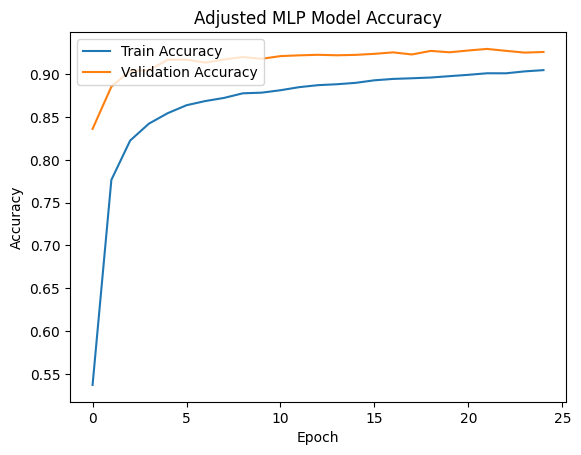

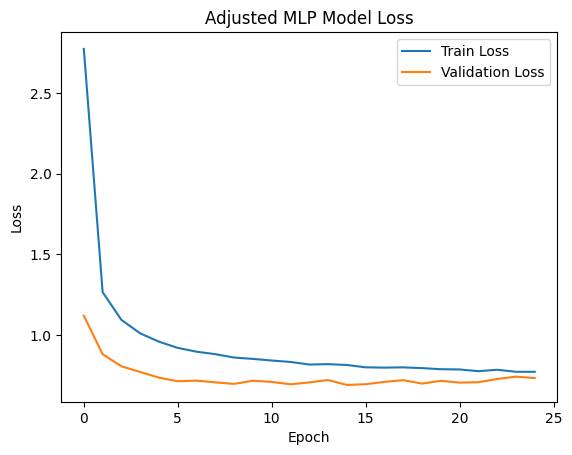

4556/4556 [==============================] - 8s 2ms/step
Adjusted MLP Train Accuracy: 0.961981464077217

Classification Report for the Adjusted MLP Model on Training Data:

              precision    recall  f1-score   support

         ADJ       0.96      0.96      0.96      9296
         ADP       0.89      0.99      0.94     12513
         ADV       0.94      0.90      0.92      7060
         AUX       0.95      1.00      0.97      8927
       CCONJ       0.93      1.00      0.96      4772
         DET       0.99      0.99      0.99     11485
        INTJ       0.81      0.05      0.09       456
        NOUN       0.99      0.98      0.98     24592
         NUM       0.98      0.93      0.95      2899
        PART       0.98      0.99      0.99      4018
        PRON       0.97      0.99      0.98     13081
       PROPN       0.96      0.99      0.97      8903
       PUNCT       0.98      1.00      0.99     16588
       SCONJ       0.81      0.45      0.58      2678
         SYM    

In [ ]:
# Building the adjusted MLP model with increased regularization and dropout
adjusted_mlp_model = Sequential([
    # Adding input layer
    Input(shape=(window_size,), dtype='int32', name='Input_Layer'),

    # Adding embedding layer
    Embedding(input_dim=embedding_matrix.shape[0], output_dim=300, weights=[embedding_matrix], trainable=True),

    # Flattening the embeddings
    Flatten(),

    # Adding dense layers with dropout and regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.8),
    Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.8),

    # Adding output layer
    Dense(len(train_target), activation='softmax')
])

# Printing the model summary for verification
print(adjusted_mlp_model.summary())

# Compiling the adjusted MLP model
adjusted_mlp_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[CategoricalAccuracy()])

# Setting up early stopping callback
early_stopping = EarlyStopping(patience=5, verbose=2, restore_best_weights=True, monitor='val_loss', mode='min')

# Training the adjusted MLP model
history = adjusted_mlp_model.fit(
    np.array(train_windows_tokenized), train_tags_onehot,
    validation_data=(np.array(dev_windows_tokenized), dev_tags_onehot),
    batch_size=256, epochs=10, shuffle=True,
    callbacks=[Metrics(valid_data=(np.array(dev_windows_tokenized), dev_tags_onehot)), early_stopping]
)

# Plotting training and validation accuracy
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Adjusted MLP Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Adjusted MLP Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Evaluating the adjusted MLP model on the training set
train_predictions_adjusted_mlp = adjusted_mlp_model.predict(np.array(train_windows_tokenized))
train_predictions_adjusted_mlp = np.argmax(train_predictions_adjusted_mlp, axis=-1)

# Converting one-hot encoded tags back to their original form for comparison
flat_train_tags_encoded = label_encoder.transform(list_flat_data(train_tags))

# Calculating accuracy on the training set
adjusted_mlp_train_accuracy = accuracy_score(flat_train_tags_encoded, train_predictions_adjusted_mlp)
print(f"Adjusted MLP Train Accuracy: {adjusted_mlp_train_accuracy}")

# Generating a classification report for the adjusted MLP model on training data
adjusted_mlp_train_classification_report = classification_report(flat_train_tags_encoded, train_predictions_adjusted_mlp, target_names=label_encoder.classes_, zero_division=0)
print("\nClassification Report for the Adjusted MLP Model on Training Data:\n")
print(adjusted_mlp_train_classification_report)

# Evaluating the adjusted MLP model on the development set
dev_predictions_adjusted_mlp = adjusted_mlp_model.predict(np.array(dev_windows_tokenized))
dev_predictions_adjusted_mlp = np.argmax(dev_predictions_adjusted_mlp, axis=-1)

# Converting one-hot encoded tags back to their original form for comparison
flat_dev_tags_encoded = label_encoder.transform(list_flat_data(dev_tags))

# Calculating accuracy on the development set
adjusted_mlp_dev_accuracy = accuracy_score(flat_dev_tags_encoded, dev_predictions_adjusted_mlp)
print(f"Adjusted MLP Development Accuracy: {adjusted_mlp_dev_accuracy}")

# Generating a classification report for the adjusted MLP model on development data
adjusted_mlp_dev_classification_report = classification_report(flat_dev_tags_encoded, dev_predictions_adjusted_mlp, target_names=label_encoder.classes_, zero_division=0)
print("\nClassification Report for the Adjusted MLP Model on Development Data:\n")
print(adjusted_mlp_dev_classification_report)

# Evaluating the adjusted MLP model on the test set
test_predictions_adjusted_mlp = adjusted_mlp_model.predict(np.array(test_windows_tokenized))
test_predictions_adjusted_mlp = np.argmax(test_predictions_adjusted_mlp, axis=-1)

# Converting one-hot encoded tags back to their original form for comparison
flat_test_tags_encoded = label_encoder.transform(list_flat_data(test_tags))

# Calculating accuracy on the test set
adjusted_mlp_test_accuracy = accuracy_score(flat_test_tags_encoded, test_predictions_adjusted_mlp)
print(f"Adjusted MLP Test Accuracy: {adjusted_mlp_test_accuracy}")

# Generating a classification report for the adjusted MLP model on test data
adjusted_mlp_test_classification_report = classification_report(flat_test_tags_encoded, test_predictions_adjusted_mlp, target_names=label_encoder.classes_, zero_division=0)
print("\nClassification Report for the Adjusted MLP Model on Test Data:\n")
print(adjusted_mlp_test_classification_report)

## Implementing stacked CNN

### Baseline CNN Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 300)            6060600   
                                                                 
 dropout_2 (Dropout)         (None, 5, 300)            0         
                                                                 
 conv1d (Conv1D)             (None, 3, 16)             14416     
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                1088      
                                                      

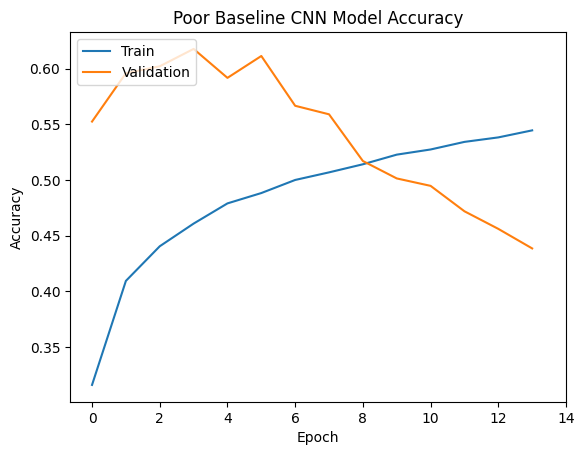

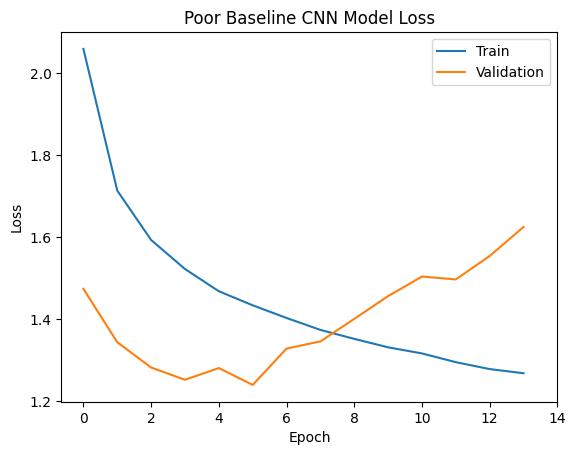


960/960 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

         ADJ       0.86      0.05      0.09      1913
         ADP       0.65      0.81      0.72      2630
         ADV       0.37      0.49      0.43      1505
         AUX       0.78      0.95      0.86      1939
       CCONJ       0.80      0.97      0.87       970
         DET       0.93      0.62      0.74      2367
        INTJ       0.00      0.00      0.00       114
        NOUN       0.41      0.90      0.57      5052
         NUM       0.68      0.24      0.35       639
        PART       0.66      0.37      0.48       851
        PRON       0.78      0.83      0.80      2839
       PROPN       0.63      0.66      0.65      1883
       PUNCT       1.00      0.48      0.64      3486
       SCONJ       0.90      0.11      0.20       564
         SYM       0.00      0.00      0.00       110
        VERB       0.76      0.37      0.50      3384
           X       0.00  

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# Define hyperparameters for the poorly performing baseline model
FILTERS = 16  # Further reduced number of filters
KERNEL = 3  # Reduced kernel size to fit within the sequence length
DENSE = 64  # Further reduced number of dense units
LAYERS = 1  # Single convolution layer
DROPOUT_RATE = 0.6  # Increased dropout probability
MAX_SEQUENCE_LENGTH = window_size
EMBEDDING_DIM = 300  # Dimensionality of embeddings

# Create empty sequential model
poor_baseline_cnn = Sequential()
# Vectorizer layer
poor_baseline_cnn.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
# Add an embedding layer
poor_baseline_cnn.add(Embedding(input_dim=len(vocabulary), output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=True))
# Add a higher dropout probability
poor_baseline_cnn.add(Dropout(DROPOUT_RATE))
# Add a single convolution layer with fewer filters
poor_baseline_cnn.add(Conv1D(FILTERS, KERNEL, activation='relu', padding='valid'))
# Max pooling
poor_baseline_cnn.add(GlobalMaxPooling1D())
# Add a higher dropout probability
poor_baseline_cnn.add(Dropout(DROPOUT_RATE))
# Add dense layer with fewer units
poor_baseline_cnn.add(Dense(DENSE, activation='relu'))
# Add final linear layer
poor_baseline_cnn.add(Dense(len(train_target), activation='softmax'))

print(poor_baseline_cnn.summary())
poor_baseline_cnn.compile(loss='categorical_crossentropy',
                          optimizer=Adam(learning_rate=0.001),
                          metrics=["categorical_accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(patience=5, verbose=2, monitor="val_categorical_accuracy", mode="max", restore_best_weights=True)

# Training the poorly performing baseline CNN model
poor_baseline_cnn_history = poor_baseline_cnn.fit(
    np.array(train_windows_tokenized), train_tags_onehot,
    validation_data=(np.array(dev_windows_tokenized), dev_tags_onehot),
    batch_size=128,
    epochs=10,
    shuffle=True,
    callbacks=[Metrics(valid_data=(np.array(dev_windows_tokenized), dev_tags_onehot)), early_stopping]
)

# Plotting training and validation accuracy
plt.plot(poor_baseline_cnn_history.history['categorical_accuracy'])
plt.plot(poor_baseline_cnn_history.history['val_categorical_accuracy'])
plt.title('Poor Baseline CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks([x_tick for x_tick in range(0, len(poor_baseline_cnn_history.history['categorical_accuracy']) + 2, 2)])
plt.show()

# Plotting training and validation loss
plt.plot(poor_baseline_cnn_history.history['loss'])
plt.plot(poor_baseline_cnn_history.history['val_loss'])
plt.title('Poor Baseline CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.xticks([x_tick for x_tick in range(0, len(poor_baseline_cnn_history.history['loss']) + 2, 2)])
plt.show()

print()

predictions = np.argmax(poor_baseline_cnn.predict(np.array(dev_windows_tokenized)), -1)
flat_dev_tags_encoded = label_encoder.transform(list_flat_data(dev_tags))
print(classification_report(flat_dev_tags_encoded, predictions, target_names=label_encoder.classes_, zero_division=0))

# Evaluating the poorly performing baseline model on the test set
test_predictions = poor_baseline_cnn.predict(np.array(test_windows_tokenized))
test_predictions = np.argmax(test_predictions, axis=-1)
flat_test_tags_encoded = label_encoder.transform(list_flat_data(test_tags))
test_accuracy = accuracy_score(flat_test_tags_encoded, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Generating a classification report
test_classification_report = classification_report(flat_test_tags_encoded, test_predictions, target_names=label_encoder.classes_, zero_division=0)
print("\nClassification Report for the Test Set:\n")
print(test_classification_report)

### CNN with n-gram filters (𝑛 = 2, 3, 4), residual connections, and a dense layer (the same at all word positions) with softmax at the top layer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 5, 300)               6060600   ['input_2[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 5, 300)               0         ['embedding_2[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 5, 300)               180300    ['dropout_4[0][0]']           
                                                                                              

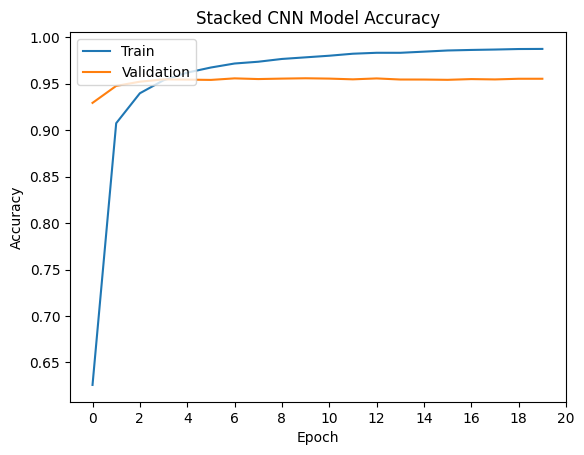

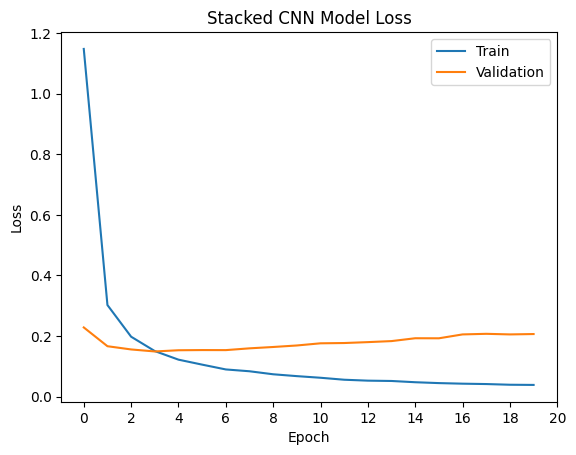


962/962 [==============================] - 2s 2ms/step
Test Accuracy: 0.9536736020806242

Classification Report for the Test Set:

              precision    recall  f1-score   support

         ADJ       0.93      0.90      0.92      1947
         ADP       0.94      0.97      0.95      2654
         ADV       0.93      0.88      0.90      1539
         AUX       1.00      0.98      0.99      1951
       CCONJ       0.97      1.00      0.98       946
         DET       0.99      0.99      0.99      2448
        INTJ       0.90      0.87      0.89       125
        NOUN       0.93      0.95      0.94      5159
         NUM       0.87      0.96      0.91       589
        PART       0.98      0.98      0.98       879
        PRON       0.98      0.99      0.98      2741
       PROPN       0.93      0.87      0.90      1834
       PUNCT       0.99      0.99      0.99      3523
       SCONJ       0.89      0.84      0.86       580
         SYM       0.75      0.89      0.82        97
   

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, Add, Lambda
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Define hyperparameters
FILTERS = EMBEDDING_DIM  # Number of filters to match embedding dimension
KERNEL_SIZES = [2, 3, 4]  # Kernel sizes for n-grams
DENSE = 128  # Number of dense units
DROPOUT_RATE = 0.5  # Dropout probability
MAX_SEQUENCE_LENGTH = window_size
EMBEDDING_DIM = 300  # Dimensionality of embeddings

# Input layer
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding layer
embedding_layer = Embedding(input_dim=len(vocabulary), output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(input_layer)
dropout_emb = Dropout(DROPOUT_RATE)(embedding_layer)

# Convolutional layers with residual connections
conv_layers = []
for kernel_size in KERNEL_SIZES:
    conv_layer = Conv1D(FILTERS, kernel_size, activation='relu', padding='same')(dropout_emb)
    conv_layers.append(conv_layer)

# Merge convolution layers
if len(conv_layers) > 1:
    merged_conv = Add()(conv_layers)
else:
    merged_conv = conv_layers[0]

# Adding residual connection
residual = Add()([dropout_emb, merged_conv])

# Global Max Pooling
global_max_pool = GlobalMaxPooling1D()(residual)

# Dropout layer
dropout_layer = Dropout(DROPOUT_RATE)(global_max_pool)

# Dense layer (same at all word positions)
dense_layer = Dense(DENSE, activation='relu')(dropout_layer)

# Output layer with softmax activation
output_layer = Dense(len(train_target), activation='softmax')(dense_layer)

# Create the model
stacked_cnn = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
print(stacked_cnn.summary())

# Compile the model
stacked_cnn.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=["categorical_accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(patience=5, verbose=2, monitor="val_categorical_accuracy", mode="max", restore_best_weights=True)

# Training the model
stacked_cnn_history = stacked_cnn.fit(
    np.array(train_windows_tokenized), train_tags_onehot,
    validation_data=(np.array(dev_windows_tokenized), dev_tags_onehot),
    batch_size=128,
    epochs=10,
    shuffle=True,
    callbacks=[early_stopping]
)

# Plotting training and validation accuracy
plt.plot(stacked_cnn_history.history['categorical_accuracy'])
plt.plot(stacked_cnn_history.history['val_categorical_accuracy'])
plt.title('Stacked CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks([x_tick for x_tick in range(0, len(stacked_cnn_history.history['categorical_accuracy']) + 2, 2)])
plt.show()

# Plotting training and validation loss
plt.plot(stacked_cnn_history.history['loss'])
plt.plot(stacked_cnn_history.history['val_loss'])
plt.title('Stacked CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.xticks([x_tick for x_tick in range(0, len(stacked_cnn_history.history['loss']) + 2, 2)])
plt.show()

print()

# Evaluating the model on the test set
test_predictions = stacked_cnn.predict(np.array(test_windows_tokenized))
test_predictions = np.argmax(test_predictions, axis=-1)
flat_test_tags_encoded = label_encoder.transform(list_flat_data(test_tags))
test_accuracy = accuracy_score(flat_test_tags_encoded, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Generating a classification report
test_classification_report = classification_report(flat_test_tags_encoded, test_predictions, target_names=label_encoder.classes_, zero_division=0)
print("\nClassification Report for the Test Set:\n")
print(test_classification_report)


### Defining the stacked CNN model, incorporating dropout for regularization and compiling the model with appropriate loss function and optimizer

In [ ]:
# # Function to build the stacked CNN model with increased regularization
# def build_stacked_cnn_model(vocab_size, embedding_matrix, input_length, num_classes, embedding_dim=300, filters=32, dense_units=128, layers=3, dropout_rate=0.5):
#     inputs = Input(shape=(input_length,))
#     embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)(inputs)
#     x = Dropout(dropout_rate)(embedding_layer)

#     # Adding multiple convolutional layers with residual connections and regularization
#     for i in range(layers):
#         conv_layer = Conv1D(filters=filters, kernel_size=(i+2), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
#         if i > 0:
#             x = add([x, conv_layer])
#         else:
#             x = conv_layer

#     x = GlobalMaxPooling1D()(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
#     x = Dropout(dropout_rate)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#     return model

In [ ]:
# # Define hyperparameters
# MAX_SEQUENCE_LENGTH = window_size  # Setting the window size as the sequence length
# EMBEDDING_DIM = 300  # Defining the dimensionality of the embeddings
# FILTERS = 32
# DENSE = 128
# LAYERS = 3
# DROPOUT_RATE = 0.5
# NUM_CLASSES = len(set(list_flat_data(train_tags)))  # Calculating the number of unique POS tags

# # Building the stacked CNN model
# cnn_model = build_stacked_cnn_model(vocab_size=len(vocabulary), embedding_matrix=embedding_matrix, input_length=MAX_SEQUENCE_LENGTH, num_classes=NUM_CLASSES, embedding_dim=EMBEDDING_DIM, filters=FILTERS, dense_units=DENSE, layers=LAYERS, dropout_rate=DROPOUT_RATE)

# # Printing the model summary
# print(cnn_model.summary())

## Model Training and Hyperparameter Tuning

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch, HyperModel, Objective

class CNNHyperModel(HyperModel):
    def __init__(self, vocab_size, embedding_matrix, num_classes):
        self.vocab_size = vocab_size
        self.embedding_matrix = embedding_matrix
        self.num_classes = num_classes

    def build(self, hp):
        input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

        # Embedding layer
        embedding_layer = Embedding(input_dim=self.vocab_size,
                                    output_dim=EMBEDDING_DIM,
                                    weights=[self.embedding_matrix],
                                    trainable=True)(input_layer)
        dropout_emb = Dropout(hp.Float('dropout_emb', 0.1, 0.5, step=0.1))(embedding_layer)

        # Convolutional layers with residual connections
        conv_layers = []
        for kernel_size in [2, 3, 4]:
            conv_layer = Conv1D(hp.Int('filters', 32, 128, step=32),
                                kernel_size,
                                activation='relu',
                                padding='same')(dropout_emb)
            conv_layers.append(conv_layer)

        # Concatenate all convolution layers
        merged_conv = Add()(conv_layers)

        # Global Max Pooling
        global_max_pool = GlobalMaxPooling1D()(merged_conv)

        # Dropout layer
        dropout_layer = Dropout(hp.Float('dropout_layer', 0.1, 0.5, step=0.1))(global_max_pool)

        # Dense layer
        dense_layer = Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu')(dropout_layer)

        # Output layer
        output_layer = Dense(self.num_classes, activation='softmax')(dense_layer)

        # Create model
        model = Model(inputs=input_layer, outputs=output_layer)

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='categorical_crossentropy',
            metrics=[CategoricalAccuracy()]
        )

        return model

# Assuming vocabulary, embedding_matrix, train_target, etc. are already defined
vocab_size = len(vocabulary)
embedding_dim = 300
num_classes = len(train_target)

# Instantiate the hypermodel
hypermodel = CNNHyperModel(vocab_size, embedding_matrix, num_classes)

# Instantiate the tuner
tuner = RandomSearch(
    hypermodel,
    objective=Objective("val_categorical_accuracy", direction="max"),
    max_trials=5, #no GPU available at the moment
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

tuner.search_space_summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=2)

# Assuming train_windows_tokenized, train_tags_onehot, dev_windows_tokenized, dev_tags_onehot are already defined

# Search for the best hyperparameters
tuner.search(np.array(train_windows_tokenized), train_tags_onehot,
             epochs=5,
             validation_data=(np.array(dev_windows_tokenized), dev_tags_onehot),
             callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters: {best_hyperparameters.values}")

# Evaluate the best model on the test set
test_predictions = best_model.predict(np.array(test_windows_tokenized))
test_predictions = np.argmax(test_predictions, axis=-1)
flat_test_tags_encoded = label_encoder.transform(list_flat_data(test_tags))
test_accuracy = accuracy_score(flat_test_tags_encoded, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Generating a classification report
test_classification_report = classification_report(flat_test_tags_encoded, test_predictions, target_names=label_encoder.classes_, zero_division=0)
print("\nClassification Report for the Test Set:\n")
print(test_classification_report)

# Save the best model
best_model.save("stacked_cnn_model.keras")

Trial 5 Complete [00h 04m 37s]
val_categorical_accuracy: 0.909261167049408

Best val_categorical_accuracy So Far: 0.9451267421245575
Total elapsed time: 00h 24m 36s
Best hyperparameters: {'dropout_emb': 0.30000000000000004, 'filters': 32, 'dropout_layer': 0.1, 'dense_units': 64, 'learning_rate': 0.00012781285101629692}
962/962 [==============================] - 3s 3ms/step
Test Accuracy: 0.9451235370611183

Classification Report for the Test Set:

              precision    recall  f1-score   support

         ADJ       0.91      0.92      0.91      1947
         ADP       0.92      0.97      0.94      2654
         ADV       0.91      0.86      0.89      1539
         AUX       0.98      0.98      0.98      1951
       CCONJ       0.98      0.99      0.99       946
         DET       0.98      0.99      0.99      2448
        INTJ       0.94      0.74      0.83       125
        NOUN       0.93      0.94      0.93      5159
         NUM       0.84      0.93      0.89       589
       

In [ ]:
# # Early stopping callback
# early_stopping = EarlyStopping(patience=10, verbose=2, monitor="val_f1", mode="max", restore_best_weights=True)

# # Training the CNN model
# history = cnn_model.fit(
#     np.array(train_windows_tokenized), train_tags_onehot,
#     validation_data=(np.array(dev_windows_tokenized), dev_tags_onehot),
#     batch_size=128,
#     epochs=50,
#     shuffle=True,
#     callbacks=[Metrics(valid_data=(np.array(dev_windows_tokenized), dev_tags_onehot)), early_stopping]
# )

# # Plotting training and validation accuracy
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('CNN Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plotting training and validation loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('CNN Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

## Model Evaluation

962/962 [==============================] - 2s 2ms/step
Test Accuracy: 0.9451235370611183

Classification Report for the Test Set:

              precision    recall  f1-score   support

         ADJ       0.91      0.92      0.91      1947
         ADP       0.92      0.97      0.94      2654
         ADV       0.91      0.86      0.89      1539
         AUX       0.98      0.98      0.98      1951
       CCONJ       0.98      0.99      0.99       946
         DET       0.98      0.99      0.99      2448
        INTJ       0.94      0.74      0.83       125
        NOUN       0.93      0.94      0.93      5159
         NUM       0.84      0.93      0.89       589
        PART       0.96      0.98      0.97       879
        PRON       0.98      0.98      0.98      2741
       PROPN       0.89      0.90      0.90      1834
       PUNCT       0.98      0.99      0.98      3523
       SCONJ       0.88      0.77      0.82       580
         SYM       0.81      0.63      0.71        97
    

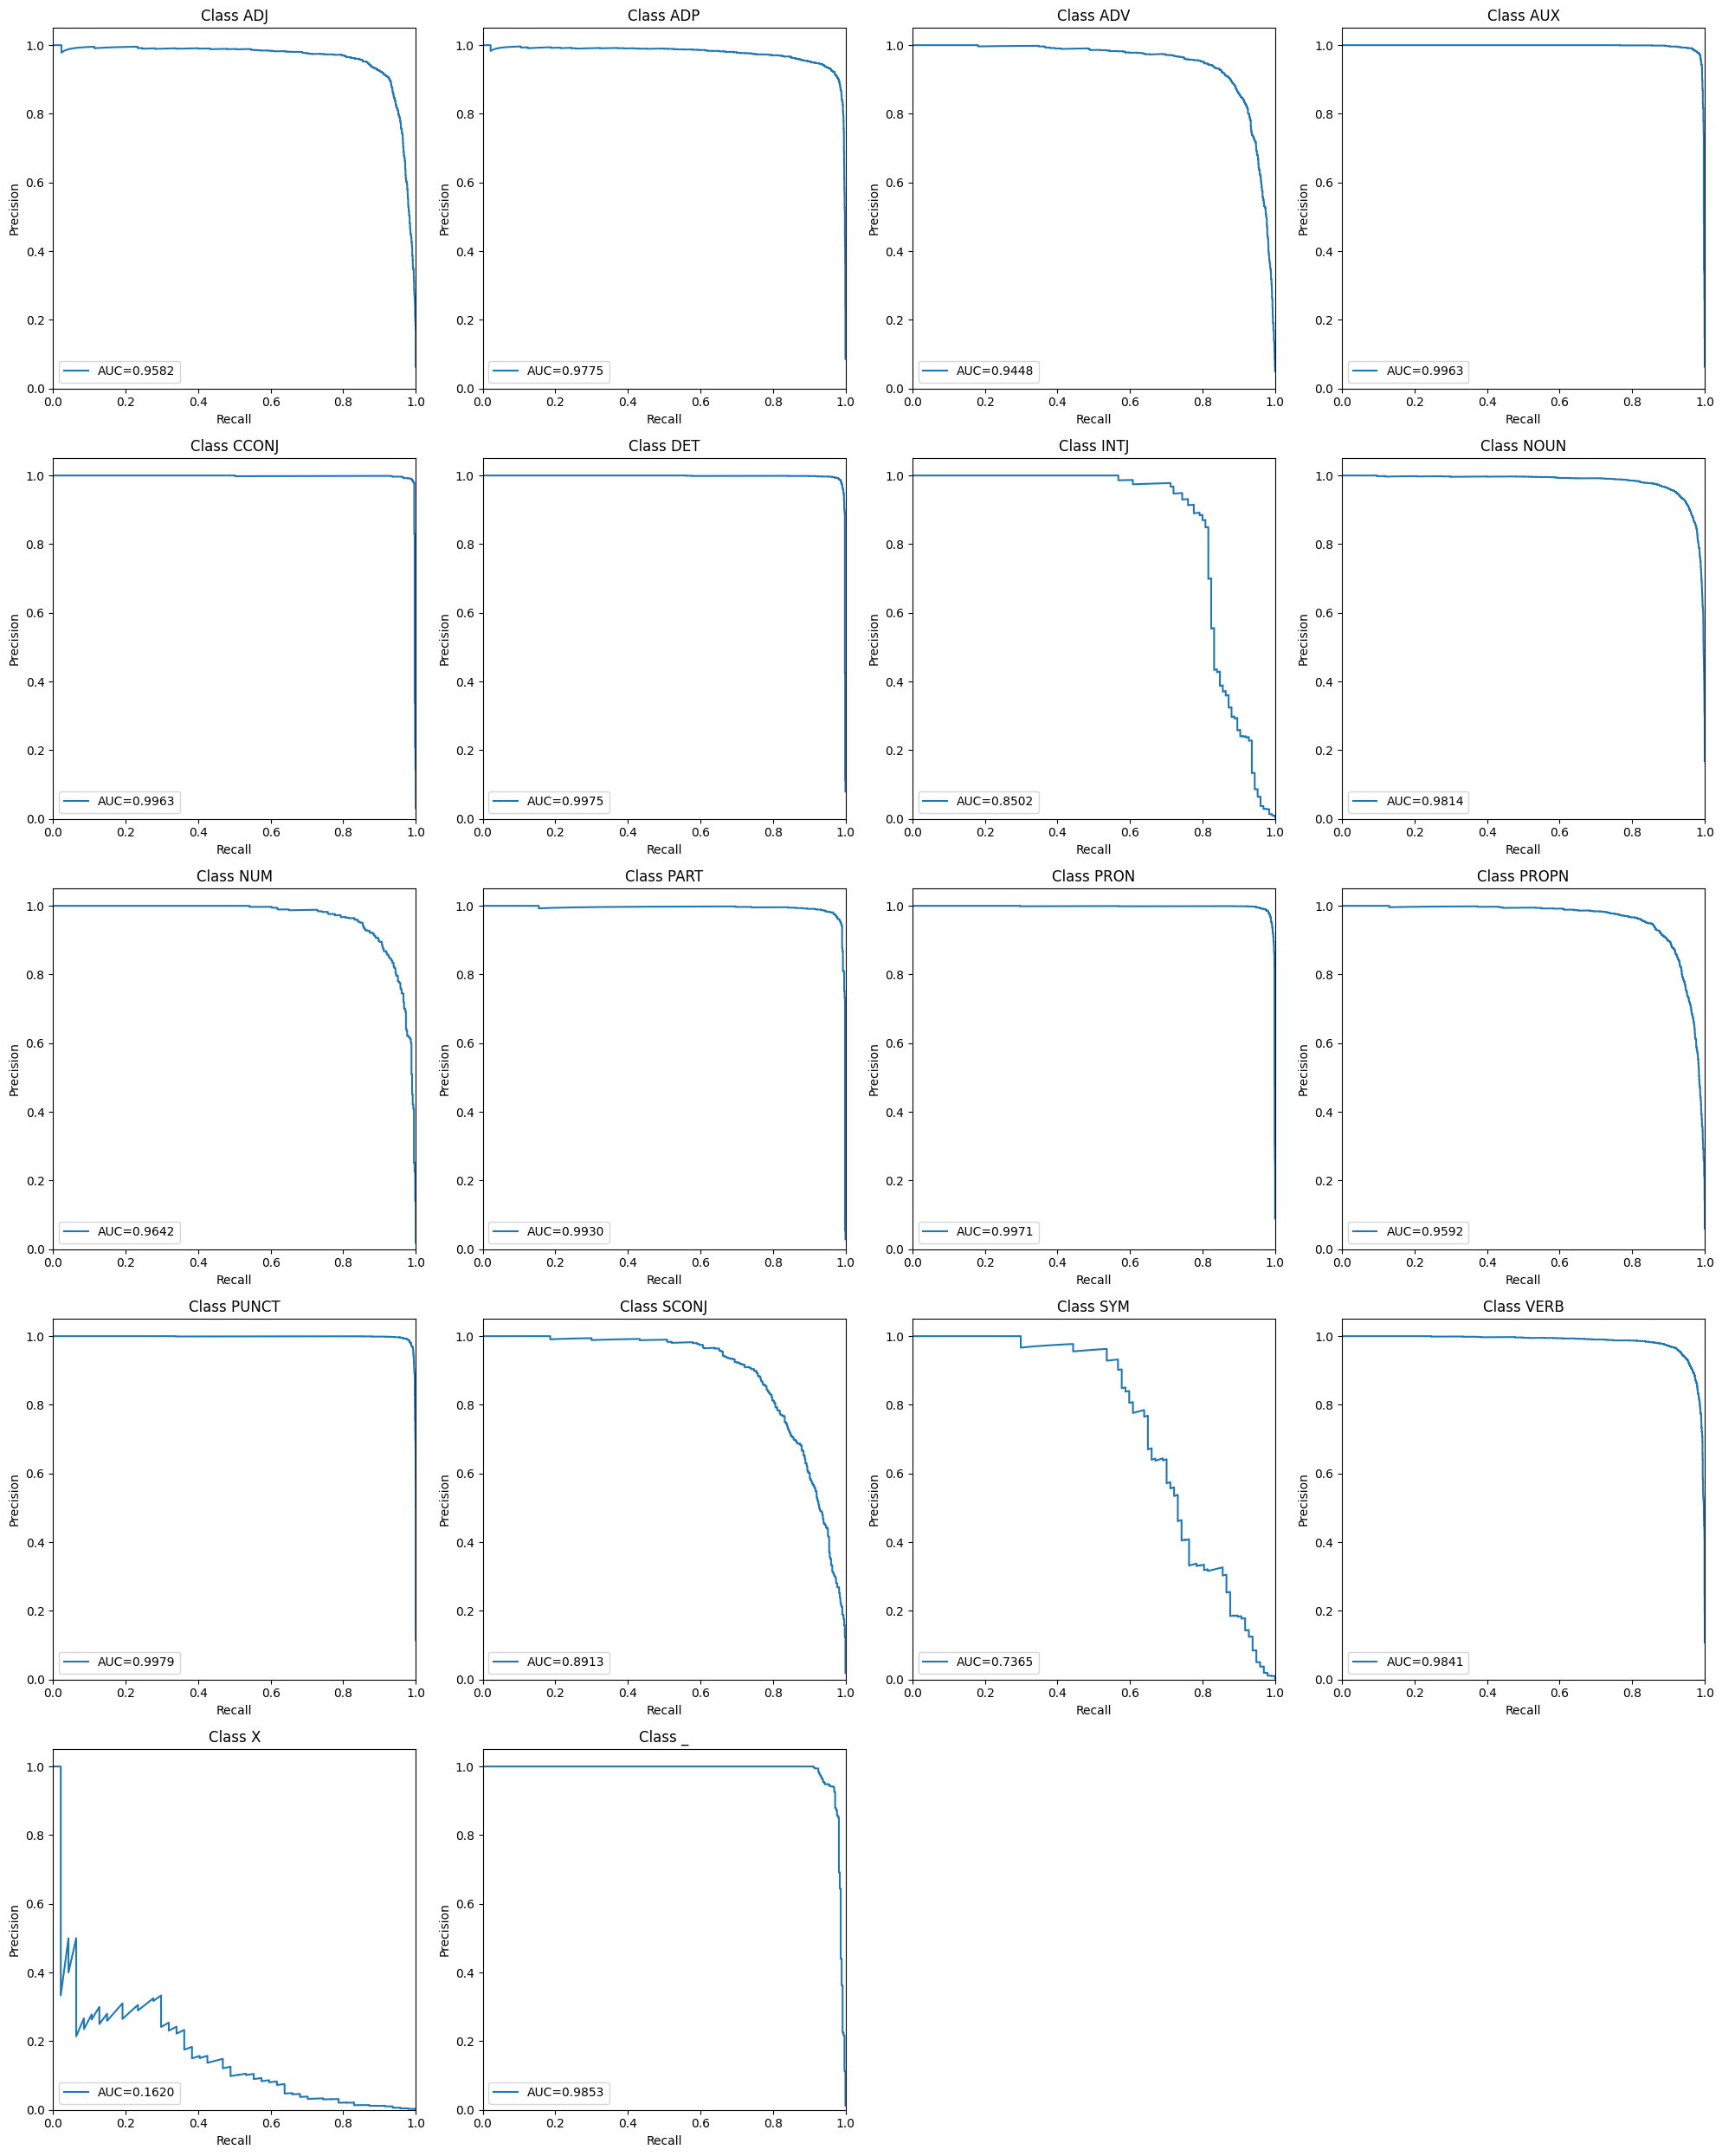

In [ ]:
# Evaluate the best model on the test set
test_predictions = best_model.predict(np.array(test_windows_tokenized))
test_predictions = np.argmax(test_predictions, axis=-1)
flat_test_tags_encoded = label_encoder.transform(list_flat_data(test_tags))
test_accuracy = accuracy_score(flat_test_tags_encoded, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Generating a classification report
test_classification_report = classification_report(flat_test_tags_encoded, test_predictions, target_names=label_encoder.classes_, zero_division=0)
print("\nClassification Report for the Test Set:\n")
print(test_classification_report)

# Save the best model
best_model.save("stacked_cnn_model.keras")

# Calculating Precision-Recall AUC for each class
# Getting the predicted probabilities
test_predictions_prob_cnn = best_model.predict(np.array(test_windows_tokenized))

# Calculating the number of rows and columns for the subplot grid
num_classes = len(label_encoder.classes_)
num_cols = 4
num_rows = (num_classes + num_cols - 1) // num_cols  # Calculate number of rows needed

# Creating a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flattening axes array for easy iteration
axes = axes.flatten()

# Calculating Precision-Recall AUC for each class and plotting the Precision-Recall curve
for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(flat_test_tags_encoded == i, test_predictions_prob_cnn[:, i])
    pr_auc = auc(recall, precision)
    print(f'Class {class_name}: Precision-Recall AUC = {pr_auc:.4f}')

    # Plotting the Precision-Recall curve in the corresponding subplot
    axes[i].plot(recall, precision, label=f'AUC={pr_auc:.4f}')
    axes[i].set_title(f'Class {class_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].legend(loc="lower left")

# Removing any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjusting layout
plt.tight_layout()
plt.show()

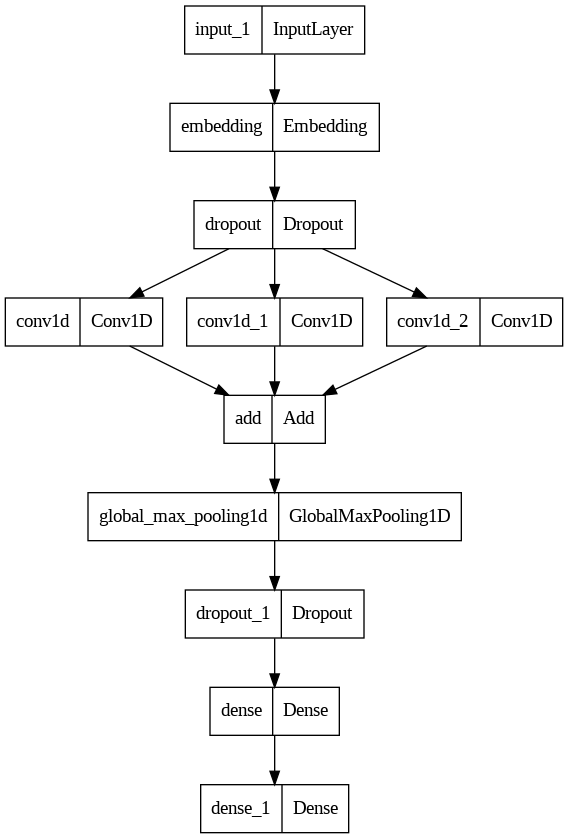

In [43]:
%matplotlib notebook

from tensorflow.keras.utils import plot_model
plot_model(best_model, to_file='model.png')

from IPython.display import Image
Image('model.png')